# More Advanced Eryn Examples

In [1]:
import numpy as np

from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.moves import GaussianMove
from eryn.backends import HDFBackend

# make the plots look a bit nicer with some defaults
import matplotlib as mpl
import matplotlib.pyplot as plt
rcparams = {}
rcparams["axes.linewidth"] = 0.5
rcparams["font.family"] = "serif"
rcparams["font.size"] = 22
rcparams["legend.fontsize"] = 16
rcparams["mathtext.fontset"] = "stix"
rcparams["text.usetex"] = True 
mpl.rcParams.update(rcparams) # update plot parameters

# set random seed
np.random.seed(42)

from chainconsumer import ChainConsumer
from scipy import interpolate

## Searching for Gaussian pulses in 2D 

In this simple example we generate a noisy figure, which contains signals in the shape of 2D Gaussian pulses. We will attempt to estimate the nubmer of signals, as well as the level of the synthetic noise. First, we generate the data.

In [2]:
num     = 100 # the number of step for each dimension
lowlim  = -10 # Low limit on each axis
highlim = 10  # high limit on each axis
npulses = 10  # The # of injected pulses

dx = (highlim - lowlim)/num # Get the discritization 

x, y    = np.mgrid[lowlim:highlim:dx, lowlim:highlim:dx] # Generate the grid

Now we define the parameters of the injection signals

In [3]:
Amp    = np.random.uniform(.5, 1.5, size=(npulses)) # Draw an amplitude
spread = .2  # Keep their spread as fixed for simplicity. 
sigma  = spread * np.diag(np.ones(2))

Do the actual injection

In [4]:
edges = 2 # Utility parameter, in order to avoid having signals at the border of our data set
 
# Draw the coordinates parameters
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

# Gather all parameters here
gauss_inj_params = [ [AA, xy[0], xy[1]] for AA, xy in zip(Amp, inj_coordinates)]

print(' * Parameters injected: \n\n', np.matrix(gauss_inj_params))

 * Parameters injected: 

 [[ 0.87454012 -7.67064809  7.51855763]
 [ 1.45071431  5.31908225 -4.60257423]
 [ 1.23199394 -5.09080052 -5.06552784]
 [ 1.09865848 -3.13212411  0.39610291]
 [ 0.65601864 -1.0888797  -3.34033376]
 [ 0.65599452  1.78964632 -5.76809823]
 [ 0.55808361 -3.32568562 -2.13821051]
 [ 1.36617615 -0.70288025  4.56281538]
 [ 1.10111501 -4.80521949  0.22775101]
 [ 1.20807258  1.4786331  -7.2567934 ]]


We then can define the model and likelihood functions

In [5]:
# First we compute some constant terms of the Gaussian models (reminder: we have assumed a fixed spread for each pulse)
sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

def gaussian_flat(x, y, a, b, c):
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; 
    pos[:, :, 1] = y
    mu = [b, c]
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return a * np.exp(- fac / 2) / norm

def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    # breakpoint()
    A = np.exp(-((x[:, None] - b) ** 2) / (2 * sigma[0,0]))
    B = np.exp(-((y[:, None] - c) ** 2) / (2 * sigma[1,1])) 
    # breakpoint()
    C =  A*B[:,None,:] # (np.expand_dims(A,axis=0) * np.expand_dims(np.transpose(B),axis=2))
    
    return np.transpose( a * C / norm , axes=(1,0,2))

def log_prob_fn(x, groups, X, Y, data, inds=None, fill_inds=[], fill_values=None):

    x1, x2 = x
    group1, group2 = groups
    a = x1[:, 0]
    b = x1[:, 1]
    c = x1[:, 2]
    n = num * num

    gauss_out  = gaussian(X, Y, a, b, c)
    num_groups = int(group1.max() + 1)
    template   = np.zeros((num_groups, num, num))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)
        given_signal = gauss_out[:,:,inds1].squeeze().sum(axis=-1)
        template[i] += given_signal

    sig = np.atleast_2d(x2)[:,0]
    llh = - 0.5 * ( np.sum(((template - data)) ** 2, axis=(1, 2)) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

We then generate the noise and add our injections.

In [6]:
sigma_noise = [[0.2]] # The nosie variance

noise = sigma_noise[0][0] * np.random.randn( num, num ) # Draw the random points for the noise

# Generate the data-set
injection = np.zeros( (num, num) )
for params in gauss_inj_params:
    injection += gaussian_flat(x, y, *params)
data = injection + noise

params = np.array(gauss_inj_params)

Plot everything below

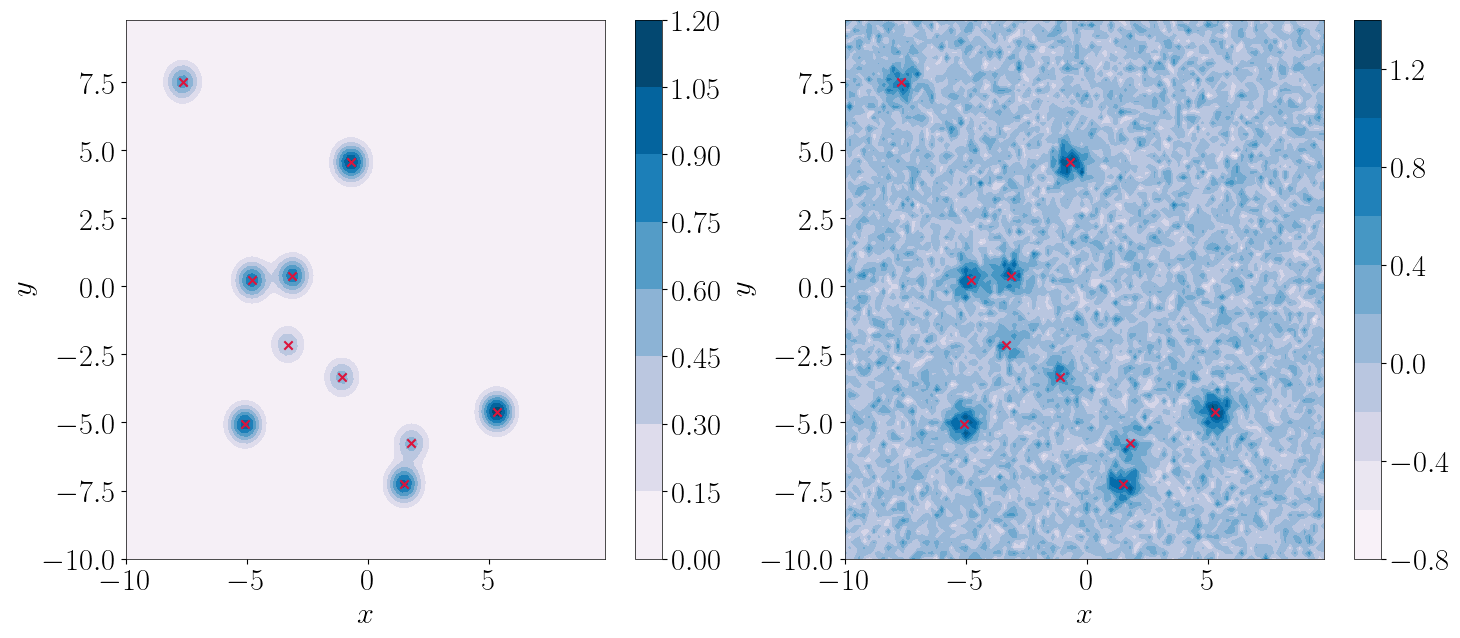

In [7]:
from matplotlib import cm

plt.figure(figsize=(17,7))
plt.subplot(121)
cf = plt.contourf(x, y, injection, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.colorbar(cf)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(122)
cf = plt.contourf(x, y, data, 10, cmap=cm.PuBu)
plt.scatter(params[:,1], params[:,2], marker='x', color='#DC143C')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(cf)
plt.show()

We then need to configure models and set-up our sample, in a very similar manner as we did for the simpler case before. Like in the previous case, we have two models that we need to sample for. One refers to the pulse signals, which we need to also estimate their total number in the data, and the other is the overal noise (no dynamical parameter space here).   

In [8]:
ndims        = [3, 1]           # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
nleaves_max  = [2*npulses, 1]   # Maximum number of components for each model type (noise is 1, because we don't want to use RJ MCMC on it).
branch_names = ["pulse", "noise"] 

priors = {
    "pulse": {
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    },
    "noise": {
        0: uniform_dist(0.000001, 2.),
    }
}

Below we generate the coordinates for each walker, as done before. First we need to define the number of Temperatures and walkers we want to use.

In [9]:
ntemps = 10
nwalkers = 30

In [10]:
coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

sig1 = 0.0000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if name == "pulse":
            if nn >= len(gauss_inj_params):
                kk = np.random.randint(low=0, high=npulses)
            else: 
                kk = nn
            coords[name][:, :, kk] = np.random.multivariate_normal(gauss_inj_params[kk], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))
        else:
            coords[name][:, :, nn] = np.random.multivariate_normal(sigma_noise[nn], np.diag(np.ones(1) * sig1), size=(ntemps, nwalkers))  


inds = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['pulse'][:, :, :3] = True

for name, inds_temp in inds.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

# We compute the initial likelihood value at the injected coordinates:
log_prob = log_prob_fn(
    [coords_in["pulse"], coords_in["noise"]],
    [groups_in["pulse"], groups_in["noise"]],
    x,
    y,
    data,
    fill_inds=[],
    fill_values=None,
)

What remains is to sample the dynamical parameter space! One last thing: Define proposal and initial temperature ladder:

In [11]:
factor = 0.0001
cov    = {"pulse": np.diag(np.ones(3)) * factor, 
          "noise": np.diag(np.ones(1)) * factor}
moves = GaussianMove(cov)
betas = np.linspace(1.0, 0.0, ntemps)

Begin sampling. This might take a while, so you can reduce the `burnin` and `nsteps` to get a quick result. With current settings it ight take between 2 - 5 minutes.

In [12]:

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    update_iterations=1,
    plot_iterations=-1,
    vectorize=True,
    moves=moves,
    rj_moves=True,
)

nsteps = 500 # Number of samples per walker

state = State(coords, log_like=log_prob.reshape(ntemps, nwalkers), betas=betas, blobs=None, inds=inds)
ensemble.run_mcmc(state, nsteps, burn=100, progress=True, thin_by=1)


100%|██████████| 500/500 [02:26<00:00,  3.41it/s]


We then plot the results below

In [13]:
def get_clean_chain(coords, ndim, temp=0):
    """Simple utility function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

In [14]:
pulse_parameters = ["$A$", r"$x$", r"$y$"]
noise_parameters = ["$\sigma_\mathrm{noise}$"]

samples_pulses = get_clean_chain(ensemble.backend.get_chain(thin=1)['pulse'], ndims[0])
samples_noise = get_clean_chain(ensemble.backend.get_chain(thin=1)['noise'], ndims[1])

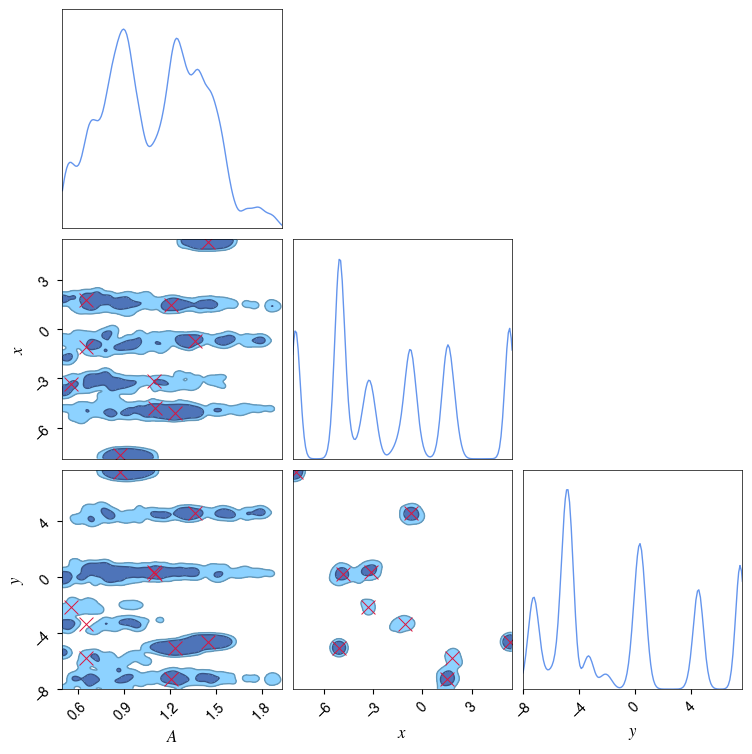

In [15]:
c = ChainConsumer()

c.add_chain(samples_pulses, parameters=pulse_parameters, name='Pulses', color='#6495ed')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)

for ii in range(npulses):
    c.add_marker([gauss_inj_params[ii][0], gauss_inj_params[ii][1], gauss_inj_params[ii][2]], \
    parameters=pulse_parameters, marker_style="x", \
    marker_size=100, color='#DC143C') 

fig = c.plotter.plot(figsize=(8,8), legend=False);

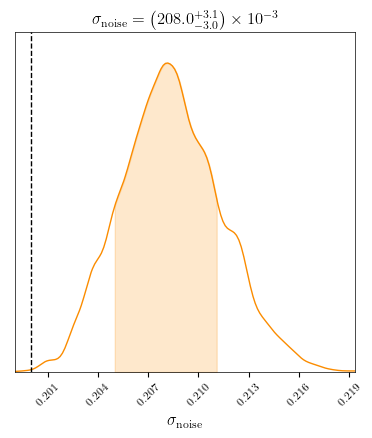

In [16]:
c = ChainConsumer()

c.add_chain(samples_noise, parameters=noise_parameters, name='noise', color='orange')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)

fig = c.plotter.plot(figsize=(4,4), legend=False, truth=sigma_noise[0]);

In [17]:
def get_clean_k_chains(backend, temp=0):
    """ A simple function to get the chains of model order k

    Args:
        backend: The Eryn backend

    Returns:
        k_chain: the chains of the k order        
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain

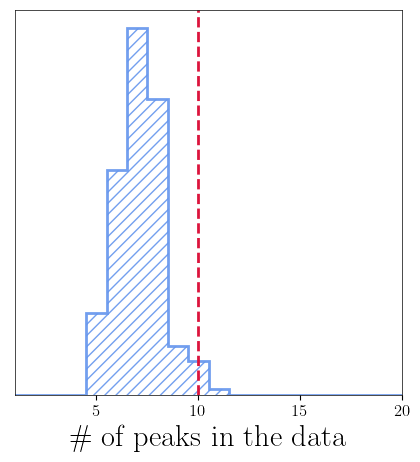

In [18]:
gauss_k_chain_baseline = get_clean_k_chains(ensemble.backend)

bns = (np.arange(1, nleaves_max[0] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

fig = plt.figure(figsize=(5, 5))
plt.hist(
        gauss_k_chain_baseline-1,
        bins=bns,
        color='#6495ed',
        alpha=0.9,
        lw=2,
        histtype='step',
        density=True,
        hatch='///'
        )

plt.axvline(x=int(npulses), linestyle='--', lw=2, color='#DC143C')

plt.xticks(fontsize=12)
plt.yticks([])
plt.xlim(1, 20)
plt.xlabel("$\#$ of peaks in the data")
plt.show()

## Choosing the optimal B-Spline order

In this section we will attempt to fit a spectrum using a shape-agnostic model based on B-spline interpolation. The motivation of the problem is to determine the optimal number of free knots that are best describing the data, avoiding over-fitting situations. A very useful package is [this](https://github.com/karnesis/spectral) one, which is a simple package for performing spectral analysis. Has a lot of window functions, but more importantly, it contains the log-PSD function, which we will use in order to reduce the computational complexity of the problem. For more invormation about the `lpsd` method you can check [this](https://pure.mpg.de/rest/items/item_150688/component/file_150687/content) paper. 

First we set-up the type of measurement. The duration, cadence, also try to define the total number of steps for our sampler.

In [2]:
Tobs  = 1e6                     # Duration of data 
dt    = 10                      # Delta-t [s]
fs    = 1/dt                    # Sampling frequency
Ndata = int(Tobs/dt)            # Number of data points
tvec  = np.arange(0, Tobs, dt)  # Get the time vector
df    = 1.0/Tobs                # Define Delta-f
burnin=1000
nsteps=2000

We then need to simulate some time-series. We could totally do this directly in frequency domain, but we will generate synthetic time series in order to use the `lpsd` function, which is useful for now. We start by defining our "true", or "theoretical" PSD of the data, which we will use to generate our data-set.

In [3]:

if (Ndata % 2)==0:              # Get the number of requencies
    nfft = int((Ndata/2)+1)
else:
    nfft = int((Ndata+1)/2)

F     = df*nfft                 # make the positive frequency vector
fvec  = np.arange(0, F, df)

# Define a smooth model for the PSD of the noise
fstar=8e-3
n1=-5
n2=5
amp = 1
noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )

# Get the PSD of the noise using hte model above
Sn = noisemodel(fvec)

# Remove first nan (assume also zero-mean)
Sn[0] = 0

/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_12400/1282363938.py:14: RuntimeWarning: divide by zero encountered in true_divide
  noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_12400/1282363938.py:14: RuntimeWarning: divide by zero encountered in power
  noisemodel = lambda f : 1e-3/f + 50*f + amp * (f**(n1 + n2) / (fstar**n1 * f**n2 + fstar**n2 * f**n1) )


Import the spectral module for convenience. It contains tons of windows and some spectral utility functions.

In [4]:
from spectral import genTimeSeriesFromPSD, lpsd, welchpsd

We generate the time-series by `ifft`-ing from the PSD model we provided. We then compute the PSD of the data using hte Welch method. 

In [8]:
navs = 30

## Generate time-series here
print('\n # Generating noisy data with \n\t Tobs: {} \n\tNdata: {} \n\t  dt: {} \n\t  df: {}\n\t '.format(Tobs, Ndata, dt, df))
my_data = genTimeSeriesFromPSD(Sn,fs) # I divide by two because the function assumes the 2-sided spectrum

f20, S20 = welchpsd(my_data, fs, int(Ndata/navs), win='nuttall4c')
fr1, S1 = welchpsd(my_data, fs, Ndata, win='nuttall4c')



 # Generating noisy data with 
	 Tobs: 1000000.0 
	Ndata: 100000 
	  dt: 10 
	  df: 1e-06
	 


In order to save some computatational time, we use the `lpsd` method, which is basically a method to compute the PSD of time-series, using the optimal number of averages at each frequeny. The frequency grid is equally spaced in log, and pre-defined. For more information, you can tcheck [this](https://www.sciencedirect.com/science/article/abs/pii/S026322410500117X?via%3Dihub) paper.

In [9]:
f0 = 1e-4
f1 = 5e-2

fl, Sl, Sle, _, Kavs = lpsd(my_data, fs, Kdes=100, Jdes=200, flims=[f0, f1], win='nuttall4b', winalpha=0., olap=0.0, order=0, errrype='std', DOPLOT=False, VERBOSE=False)
errs = [np.absolute(Sle[0]), np.absolute(Sle[1])]

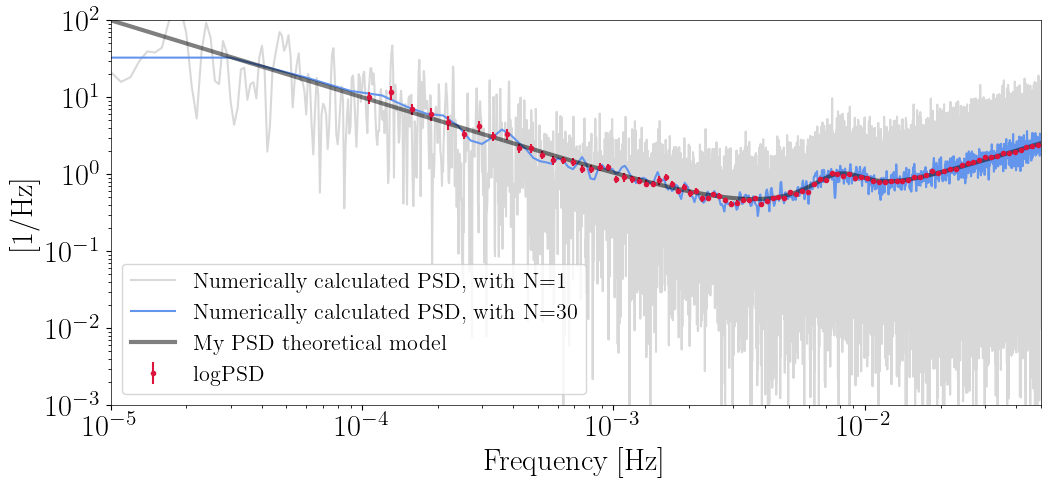

In [10]:
plt.figure(figsize=(12,5))
plt.loglog(fr1, S1, label='Numerically calculated PSD, with N=1', color='grey', alpha=.3)
plt.loglog(f20, S20, label=f'Numerically calculated PSD, with N={navs}', color='cornflowerblue')
plt.errorbar(fl, np.absolute(Sl), yerr=errs, fmt='.', label='logPSD', color='crimson')

plt.loglog(fvec, Sn, alpha=0.5, color='k', linewidth=3, label='My PSD theoretical model')
plt.xlim(1e-5, fvec[-1])
plt.ylim(1e-3, 1e2)
plt.ylabel('[1/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend(loc='lower left')

Now we setting up the sampler.

In [25]:
maxmodels = 20
ntemps = 10
nwalkers = 10
backendname = 'a_test'

For this investigation, we need two models. One model concerns the knots at the edges of the spectrum, which we only do parameter estimation for their respective amplitude. So, no reversible jump for this one. We do this by simply setting the maximum number of leaves to `1`. The second model is the one that is dynamic, each component having an amplitude and a position parameter. We call those models `edges` and `knots` respectively.   

In [26]:
ndims        = [2, 2] # The first is control point + knot, the second two control points (knots are the edges)
nleaves_max  = [maxmodels, 1]
nleaves_min  = [2, 1]
branch_names = ["knots", "edges"]

# Restrict the frequency band
i_band = np.where((fl>=f0) & (fl<=f1))[0]

mx = np.max(np.log(noisemodel(fl[i_band])))
mn = np.min(np.log(noisemodel(fl[i_band])))

print('max:', mx)
print('min:', mn)

#The prior on the knot amplitude could be dependent on the frequency, but I choose
#to be simple here
priors = {
    "knots": {
        0: uniform_dist(np.log(f0), np.log(f1)),
        1: uniform_dist(1.5*mn, 1.2*mx),
    },
    "edges": {
        0: uniform_dist(1.5*mn, 1.2*np.log(noisemodel(fl[0]))),
        1: uniform_dist(1.5*mn, 1.3*np.log(noisemodel(fl[-1]))),
    }
}

max: 2.2400506683151953
min: -0.7418475507541406


Setting up the input coordinates. This might be easier in the future, but hte functionality should remain.

In [27]:

# Initialize the knots fr, 
coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}


sig1 = 0.0001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    print('# {}: Max models = {}, dim = {}'.format(name, nleaf, ndim))
    for nn in range(nleaf):
        if name == "knots":
            for dd in range(ndim):
                coords[name][:, :, nn, dd] = priors['knots'][dd].rvs(size=(ntemps,nwalkers))
        else:
            for dd in range(ndim):
                coords[name][:, :, nn, dd] = priors['edges'][dd].rvs(size=(ntemps,nwalkers)) # np.random.multivariate_normal(edges_starting_params[nn], np.diag(np.ones(2) * sig1), size=(ntemps, nwalkers))  

indxs = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

indxs['knots'][:, :, :3] = True

for name, inds_temp in indxs.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][indxs[name]] for name in coords}
groups_in = {name: groups[name][indxs[name]] for name in groups}

# knots: Max models = 20, dim = 2
# edges: Max models = 1, dim = 2


Now we need to define the likelihood function. It hadles

In [28]:
class SplineLikelihood:

    def __init__(self, freq, per, N, inf=1e14, expmax = 500, kind='cubic', ftol=.1):
        """
        Gaussian likelihood model using a log-periodogram.

        Parameters
        ----------
         fr : (ndarray) frequency array of the estimation domain, size nf
        per : (ndarray) periodogram array, size nf 
          N : (ndarray) array of averages per frequency, size nf 
        var : (float) variance of the log-periodogram bins
        inf : (float or np.inf) if the likelihood diverges, it will be set equal to - inf
     expmax : (float) maximum value allowed in the exponential function. If this is reached, the log-likelihood will return -infinity.
       kind : (string) Interpolation kind. Set to 'cubic' by default.
       ftol : (float [ 0 < ftol]) Tolerance on proximity of knots in logspace
        """

        # Frequency of data
        self.freq   = freq
        self._Nsegs = N
        self._N     = len(freq)
        self.logfr  = np.log(freq)
        # Discrete Fourier transform of data (already normalized)
        self.per = per
        # Maximum value allowed in the exponential function
        self.expmax = expmax
        # Interpolation kind
        self.kind = kind
        # tolerance on proximity of knots in logspace
        self.ftol = ftol
        self.inf = inf

    def get_noise_psd_model(self, x, groups):
        """Get the spline model for the noise PSD, given some knots

        Parameters
        ----------
        x, groups : (ndarray) PSD parameters

        Returns
        -------
        psd_model : interpolate.interp1d evaluated
        """
        
        # I will consider two models. One handling the internal knots, and one for the edges
        internal_knots_parameters, control_points_edges = x
        group1, group2 = groups
        knots = internal_knots_parameters[:, 0]
        control_points = internal_knots_parameters[:, 1]

        num_groups = int(group1.max() + 1)
        # log_psd_model = np.zeros((num_groups, len(self.freq)))
        log_psd_model = np.empty((num_groups, len(self.freq)))
        log_psd_model[:] = np.nan

        # Loop over the temperatures vs walkers
        for i in range(num_groups):
            inds1 = np.where(group1 == i)
            knots_i = knots[inds1]
            control_points_i = control_points[inds1]

            inds2 = np.where(group2 == i)
            control_points_edges_i = np.squeeze(control_points_edges[inds2])

            # Remove zeros 
            knots_i  = knots_i[knots_i != 0.]
            control_points_i = control_points_i[control_points_i != 0.]

            knots_list  = np.array([self.logfr[0]] + list(knots_i) + [self.logfr[-1]])
            control_pts = np.array([control_points_edges_i[0]] + list(control_points_i) + [control_points_edges_i[-1]])
            
            # Control for knots very close to each other
            if not np.any(np.diff(np.array(knots_list)) < self.ftol):
                # Change the data and reset the spline class
                interp_model = interpolate.interp1d(knots_list, control_pts, 
                	                                kind=self.kind, axis=-1, copy=True, 
                        	                        bounds_error=False,
                                	                fill_value="extrapolate",
                                        	        assume_sorted=False)
                log_psd_model[i] = interp_model(self.logfr)

                # To prevent overflow
                if np.any(log_psd_model[i] > self.expmax):
                    print('[Overflow!]')
                    i_over = np.where((log_psd_model[i] > self.expmax) | (np.isnan(log_psd_model[i])))
                    log_psd_model[i][i_over] = np.nan
        # Return the correct quantity
        return np.exp(log_psd_model)

    def evaluate(self, x, groups):
        """
        Calculate the log-likelihood.

        Parameters
        ----------
             x : (ndarray) vector of spline parameters.
        groups : (ndarray) vector of groups parameters.

        Returns
        -------
             L : (ndarray) log-likelihood value at x, groups computed.
        """
        # Compute PSD model
        C = self.get_noise_psd_model(x, groups)
                
        # Get the normalisation constants
        log2pi = - self._N * np.log(2.0*np.pi)
        
        # Log-likelihood calculation
        L = -1.* self.per / C
        
        # Sum with the normalization factor here
        L = np.nan_to_num(.5 * self._Nsegs * ( L - np.log(C) + log2pi), nan= -np.inf)
        L = np.sum(L, axis=-1) 
        L[~np.isfinite(L)] = -self.inf
        return L

In [29]:
# Instantiate and initalize likelihood again with different ftol
psdlike = SplineLikelihood(fl[i_band].squeeze(), np.real(Sl[i_band]), Kavs[i_band], ftol=.05)

liekeval = psdlike.evaluate([coords_in["knots"], coords_in["edges"]], [groups_in["knots"], groups_in["edges"]])

print('llh shape = ', liekeval.shape)
print('liekeval = ', liekeval)

log_prob = liekeval.reshape(ntemps, nwalkers)

llh shape =  (100,)
liekeval =  [-4.29905751e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -4.37617254e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -4.30751294e+06 -4.31923024e+06 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -4.31360092e+06 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14
 -1.00000000e+14 -1.00000000e+14 -1.00000000e+14 -1.000000

Now run the sampler!

In [30]:
betas  = np.linspace(1.0, 0.0, ntemps)
factor = 0.0001
cov    = {"knots": np.diag(np.ones(2)) * factor, 
          "edges": np.diag(np.ones(2)) * factor}

moves = GaussianMove(cov)

backend = HDFBackend(backendname + ".h5")

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    psdlike.evaluate,
    priors,
    args=None,
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    provide_groups=True,
    update_iterations=1,
    plot_iterations=-1,
    moves=moves,
    rj_moves=True,
    vectorize=True,
    backend=backend, 
)

print(' * Started sampling ...')
state = State(coords, log_like=log_prob, betas=betas, blobs=None, inds=indxs)

ensemble.run_mcmc(state, nsteps, burn=burnin, progress=True, thin_by=1)

print(' * Finished sampling!')

 * Started sampling ...


 18%|█▊        | 184/1000 [00:03<00:15, 53.85it/s]/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_3250/1577252010.py:111: RuntimeWarning: divide by zero encountered in true_divide
  L = -1.* self.per / C
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_3250/1577252010.py:111: RuntimeWarning: overflow encountered in true_divide
  L = -1.* self.per / C
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_3250/1577252010.py:114: RuntimeWarning: divide by zero encountered in log
  L = np.nan_to_num(.5 * self._Nsegs * ( L - np.log(C) + log2pi), nan= -np.inf)
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_3250/1577252010.py:114: RuntimeWarning: invalid value encountered in subtract
  L = np.nan_to_num(.5 * self._Nsegs * ( L - np.log(C) + log2pi), nan= -np.inf)
/Users/nikos/work/programs/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

[Overflow!]


100%|██████████| 2000/2000 [01:00<00:00, 33.08it/s]

 * Finished sampling!


In [31]:
baseline_run_backend = HDFBackend(backendname + ".h5") # Load the data from disk

In [32]:
temp = 0 

ndim_knots = 2 # Set the dimensionality of each model
ndim_edges = 2

samples_knots = get_clean_chain(baseline_run_backend.get_chain()['knots'], ndim_knots)
samples_edges = get_clean_chain(baseline_run_backend.get_chain()['edges'], ndim_edges)

Plot the "squeezed" posterior surface for our parameters, for all `k` models.

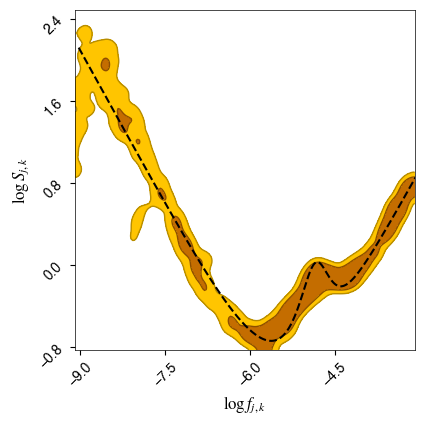

In [33]:
paramnames = [r'$\log f_{j,k}$',r'$\log S_{j,k}$'] # Define parameter names

i_band = np.where((f20>=f0) & (f20<=f1))[0] # Keep only the range which we fitted in

c = ChainConsumer()
c.add_chain(samples_knots, parameters=paramnames, name='Knots in-between', color='orange')
c.configure(bar_shade=True, plot_hists=False)
fig = c.plotter.plot(figsize=(4, 4));
ff = np.linspace(np.log(f20[i_band][0]),np.log(f20[i_band][-1]), num=1000)
ax_list = fig.axes
ax_list[0].plot(ff, np.log(noisemodel(np.exp(ff))), color='k', lw=1.5,linestyle='--')
plt.show()

mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoyinh

Text(0.5, 0, '$\\#$ of free knots')

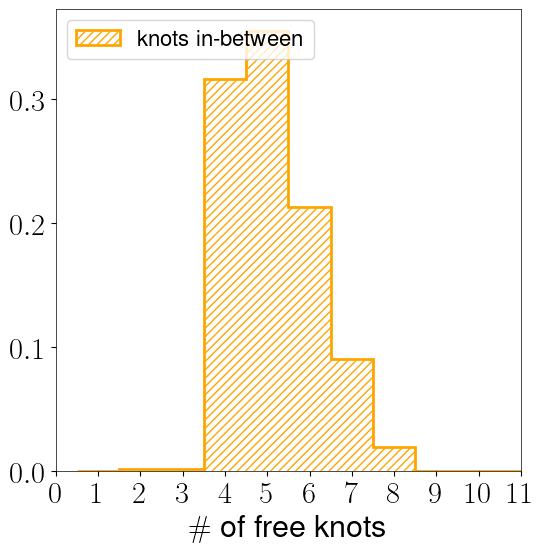

In [34]:
knots_k_chain = get_clean_k_chains(baseline_run_backend)

bns = (np.arange(1, maxmodels + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch 

mpl.rcParams['text.usetex']=True # Update this becasue chaincnsumer is annoying

fig = plt.figure(figsize=(6, 6))
probs, bins, rects = plt.hist(
        knots_k_chain-1,
        bins=bns,
        facecolor=None,
        histtype='step',
        edgecolor='orange',
        hatch='////',
        alpha=1,
        lw=2,
        density=True,
        label='knots in-between'
        )

plt.legend(loc='upper left')
plt.xticks(np.arange(0, maxmodels))
plt.xlim(0, 11)
plt.xlabel(r"$\#$ of free knots")

$\sim fin \sim$